# Distinguish Your Own Digits (DYOD)

You are going to write a classifier that distinguishes between the number 3 and number 8.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

From the command line run `pip install mnist`. This is a library that will help you bring down the mnist dataset. If you run this from a notebook, you need to put  `!pip install mnist` in a cell by itself.

In [3]:
!pip install mnist

## Preparing the Data

In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

2


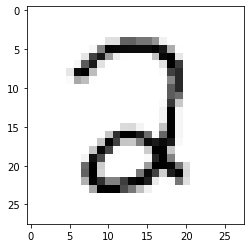

In [9]:
image_index = 7776 # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys')

## Filter data to get 3 and 8 out

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

We normalize the pizel values in the 0 to 1 range

In [11]:
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [12]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [13]:
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

In [15]:
#Impoting functions from 'Kudzu'
from kudzu.model import Model
from kudzu.train import Learner
from kudzu.optim import GD
from kudzu.data import Data, Sampler,Dataloader

from kudzu.callbacks import AccCallback
from kudzu.callbacks import ClfCallback

from kudzu.loss import MSE

from kudzu.layer import Sigmoid,Relu
from kudzu.layer import Affine

### Let us create a `Config` class, to store important parameters. 
This class essentially plays the role of a dictionary.

In [16]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 250
config.bs = 50

### Running Models with the Training data
Details about the network layers:
- A first affine layer has 784 inputs and does 100 affine transforms. These are followed by a Relu
- A second affine layer has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a Relu
- A third affine layer has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
- A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.


In [17]:
data = Data(X_train, y_train.reshape(-1,1))
sampler = Sampler(data, config.bs, shuffle=True)

dl = Dataloader(data, sampler)

opt = GD(config.lr)
loss = MSE()

In [18]:
training_data_x = X_train
testing_data_x = X_test
training_data_y = y_train.reshape(-1,1)
testing_data_y = y_test.reshape(-1,1)

In [19]:
layers = [Affine("first", 784, 100), Relu("first"), Affine("second", 100, 100), Relu("second"), Affine("third", 100, 2), Affine("last", 2, 1), Sigmoid("last")]
model_nn = Model(layers)
model_lr = Model([Affine("logits", 784, 1), Sigmoid("sigmoid")])

xavier
xavier
xavier
xavier
xavier


In [20]:
nn_learner = Learner(loss, model_nn, opt, config.num_epochs)
acc_nn = ClfCallback(nn_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
nn_learner.set_callbacks([acc_nn])

In [21]:
lr_learner = Learner(loss, model_lr, opt, config.num_epochs)
acc_lr = ClfCallback(lr_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
lr_learner.set_callbacks([acc_lr])

In [22]:
nn_learner.train_loop(dl)

Epoch 0, Loss 0.2396
Training Accuracy: 0.7856, Testing Accuracy: 0.7782



Epoch 10, Loss 0.0451
Training Accuracy: 0.9529, Testing Accuracy: 0.9567



Epoch 20, Loss 0.0345
Training Accuracy: 0.9614, Testing Accuracy: 0.9662



Epoch 30, Loss 0.0301
Training Accuracy: 0.9657, Testing Accuracy: 0.9682



Epoch 40, Loss 0.0273
Training Accuracy: 0.9686, Testing Accuracy: 0.9703



Epoch 50, Loss 0.0252
Training Accuracy: 0.9709, Testing Accuracy: 0.9718



Epoch 60, Loss 0.0237
Training Accuracy: 0.9734, Testing Accuracy: 0.9718



Epoch 70, Loss 0.0223
Training Accuracy: 0.9750, Testing Accuracy: 0.9743



Epoch 80, Loss 0.0212
Training Accuracy: 0.9767, Testing Accuracy: 0.9758



Epoch 90, Loss 0.0202
Training Accuracy: 0.9780, Testing Accuracy: 0.9763



Epoch 100, Loss 0.0193
Training Accuracy: 0.9798, Testing Accuracy: 0.9768



Epoch 110, Loss 0.0186
Training Accuracy: 0.9806, Testing Accuracy: 0.9778



Epoch 120, Loss 0.0178
Training Accuracy: 0.9815, Testing Accuracy: 0.9793



Epoch 130, Loss 0.0172
Training Accuracy: 0.9824, Testing Accuracy: 0.9798



Epoch 140, Loss 0.0166
Training Accuracy: 0.9827, Testing Accuracy: 0.9798



Epoch 150, Loss 0.016
Training Accuracy: 0.9838, Testing Accuracy: 0.9803



Epoch 160, Loss 0.0155
Training Accuracy: 0.9842, Testing Accuracy: 0.9824



Epoch 170, Loss 0.015
Training Accuracy: 0.9852, Testing Accuracy: 0.9824



Epoch 180, Loss 0.0145
Training Accuracy: 0.9855, Testing Accuracy: 0.9824



Epoch 190, Loss 0.014
Training Accuracy: 0.9859, Testing Accuracy: 0.9834



Epoch 200, Loss 0.0136
Training Accuracy: 0.9864, Testing Accuracy: 0.9834



Epoch 210, Loss 0.0132
Training Accuracy: 0.9871, Testing Accuracy: 0.9834



Epoch 220, Loss 0.0128
Training Accuracy: 0.9873, Testing Accuracy: 0.9834



Epoch 230, Loss 0.0124
Training Accuracy: 0.9876, Testing Accuracy: 0.9839



Epoch 240, Loss 0.0121
Training Accuracy: 0.9881, Testing Accuracy: 0.9839



0.0014865187342131682

In [23]:
lr_learner.train_loop(dl)

Epoch 0, Loss 0.2673
Training Accuracy: 0.5744, Testing Accuracy: 0.5963



Epoch 10, Loss 0.1082
Training Accuracy: 0.9009, Testing Accuracy: 0.9138



Epoch 20, Loss 0.0815
Training Accuracy: 0.9259, Testing Accuracy: 0.9380



Epoch 30, Loss 0.0696
Training Accuracy: 0.9357, Testing Accuracy: 0.9481



Epoch 40, Loss 0.0626
Training Accuracy: 0.9410, Testing Accuracy: 0.9516



Epoch 50, Loss 0.0579
Training Accuracy: 0.9439, Testing Accuracy: 0.9551



Epoch 60, Loss 0.0544
Training Accuracy: 0.9463, Testing Accuracy: 0.9577



Epoch 70, Loss 0.0518
Training Accuracy: 0.9483, Testing Accuracy: 0.9587



Epoch 80, Loss 0.0497
Training Accuracy: 0.9502, Testing Accuracy: 0.9592



Epoch 90, Loss 0.0479
Training Accuracy: 0.9515, Testing Accuracy: 0.9597



Epoch 100, Loss 0.0465
Training Accuracy: 0.9528, Testing Accuracy: 0.9612



Epoch 110, Loss 0.0452
Training Accuracy: 0.9539, Testing Accuracy: 0.9612



Epoch 120, Loss 0.0441
Training Accuracy: 0.9543, Testing Accuracy: 0.9617



Epoch 130, Loss 0.0432
Training Accuracy: 0.9548, Testing Accuracy: 0.9627



Epoch 140, Loss 0.0423
Training Accuracy: 0.9558, Testing Accuracy: 0.9637



Epoch 150, Loss 0.0416
Training Accuracy: 0.9563, Testing Accuracy: 0.9647



Epoch 160, Loss 0.0409
Training Accuracy: 0.9569, Testing Accuracy: 0.9652



Epoch 170, Loss 0.0403
Training Accuracy: 0.9576, Testing Accuracy: 0.9657



Epoch 180, Loss 0.0397
Training Accuracy: 0.9580, Testing Accuracy: 0.9672



Epoch 190, Loss 0.0391
Training Accuracy: 0.9584, Testing Accuracy: 0.9672



Epoch 200, Loss 0.0387
Training Accuracy: 0.9589, Testing Accuracy: 0.9672



Epoch 210, Loss 0.0382
Training Accuracy: 0.9596, Testing Accuracy: 0.9667



Epoch 220, Loss 0.0378
Training Accuracy: 0.9599, Testing Accuracy: 0.9662



Epoch 230, Loss 0.0374
Training Accuracy: 0.9602, Testing Accuracy: 0.9662



Epoch 240, Loss 0.037
Training Accuracy: 0.9602, Testing Accuracy: 0.9667



0.017656137894497614

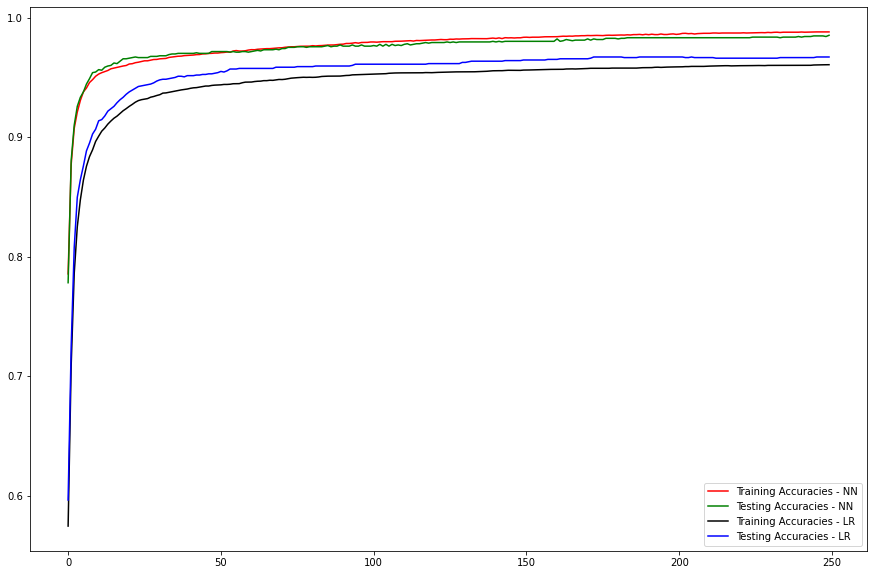

In [24]:
#comparing the results of NN and LR
plt.figure(figsize=(15,10))

# Neural Network plots
plt.plot(acc_nn.accuracies, 'r-', label = "Training Accuracies - NN")
plt.plot(acc_nn.test_accuracies, 'g-', label = "Testing Accuracies - NN")

# Logistic Regression plots
plt.plot(acc_lr.accuracies, 'k-', label = "Training Accuracies - LR")
plt.plot(acc_lr.test_accuracies, 'b-', label = "Testing Accuracies - LR")
plt.legend()

#### Plotting the outputs of this layer of the NN.


In [25]:
new_model = Model(layers[:-2])
testing_plot = new_model(testing_data_x)

Text(0.5, 1.0, 'Outputs')

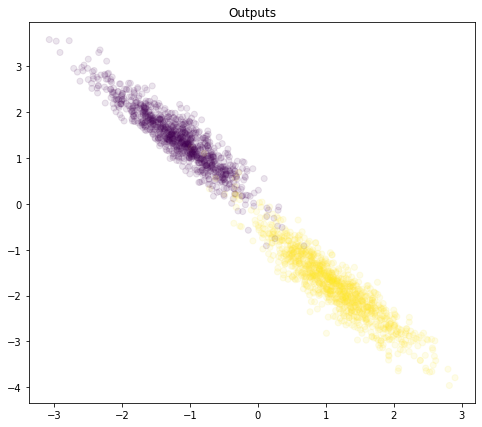

In [26]:
# Plotting the scatter plot of points and color coding by class
plt.figure(figsize=(8,7))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel());
plt.title('Outputs')

Probability contours

In [27]:
model_prob = Model(layers[-2:]) 

In [28]:
#creating the x and y ranges according to the above generated plot.
x_range = np.linspace(-4, 1, 100) 
y_range = np.linspace(-6, 6, 100) 
x_grid, y_grid = np.meshgrid(x_range, y_range) # x_grid and y_grig are of size 100 X 100

# converting x_grid and y_grid to continuous arrays
x_gridflat = np.ravel(x_grid)
y_gridflat = np.ravel(y_grid)

# The last layer of the current model takes two columns as input. Hence transpose of np.vstack() is required.
X = np.vstack((x_gridflat, y_gridflat)).T

prob_contour = model_prob(X).reshape(100,100) 

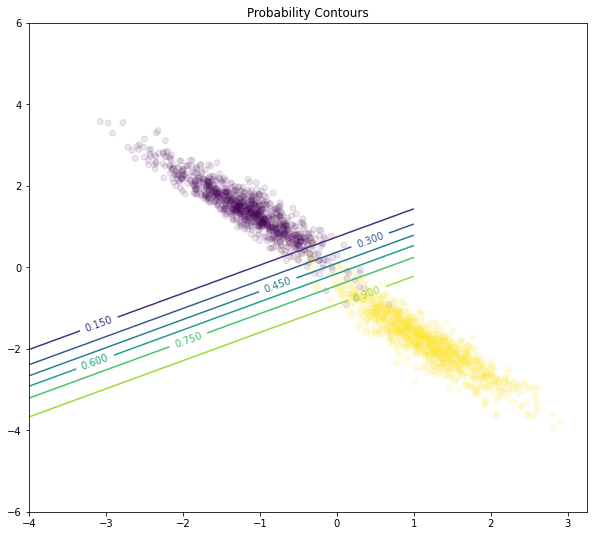

In [29]:
plt.figure(figsize=(10,9))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel())
contours = plt.contour(x_grid,y_grid,prob_contour)
plt.title('Probability Contours')
plt.clabel(contours, inline = True );